In [86]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

class SpectrogramDataset(Dataset):
    def __init__(self, spectro_folder):
        self.spectrogram_folders = list(spectro_folder.glob('spectrogram_*'))
        self.transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: torch.flatten(x)),
        ])

    def __len__(self):
        return len(self.spectrogram_folders)

    def __getitem__(self, idx):
        folder_path = self.spectrogram_folders[idx]

        # Load the spectrogram image
        img = Image.open(folder_path / 'spectrogram.png').convert('L')
        img = self.transform(img)

        # Load the label
        label_path = folder_path / 'label.txt'
        with open(label_path, 'r') as label_file:
            label = int(label_file.read().strip())

        return img, label

# Path to the folder containing your spectrograms
spectro_folder = Path('/Users/madssverker/Documents/GitHub/Bachelor_Thesis/spectrograms')

# Create a custom dataset
Data = SpectrogramDataset(spectro_folder)

batch_size = 100
dataloader = DataLoader(Data, batch_size = batch_size)

In [89]:
for batch in dataloader:
    images, labels = batch
    images = np.asarray(images)
    labels = np.asarray(labels)
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.4, shuffle = True, stratify=labels)
    
    classifier = SVC(probability=True)

    param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.0001, 0.001, 0.1, 1], 'kernel': ['rbf', 'poly']}

    model = GridSearchCV(classifier, param_grid)

    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    
    print("The predicted Data is :")
    print(y_pred)
    print("The actual data is:")
    print(np.array(y_test))
    print(f"The model is {accuracy_score(y_pred,y_test)*100}% accurate")    
    

The predicted Data is :
[5 4 3 1 1 2 2 1 4 2 4 2 1 5 2 1 5 2 5 3 4 2 2 1 5 4 4 4 4 3 4 5 1 2 3 5 3
 4 1 2]
The actual data is:
[5 4 3 1 1 1 2 1 4 2 4 2 1 5 2 1 2 5 3 3 4 2 1 1 5 4 3 4 5 3 4 5 5 2 3 5 3
 4 3 2]
The model is 77.5% accurate


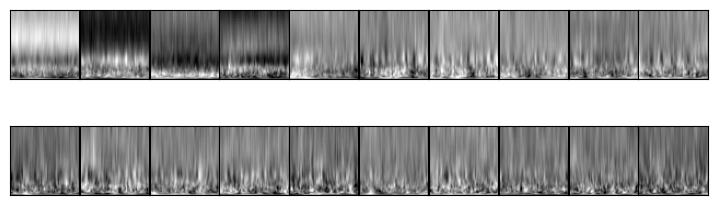

In [90]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.8)
pca.fit(x_train)
# print(pca.explained_variance_ratio_)
fig, axes = plt.subplots(2,10,figsize=(9,3),
 subplot_kw={'xticks':[], 'yticks':[]},
 gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
 ax.imshow(pca.components_[i].reshape(64,64),cmap='gray')
converted_data = pca.fit_transform(x_train)

/var/folders/n1/4326m7wx0w70v1kvdb3qhnqr0000gn/T/ipykernel_23836/543237202.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c_map = plt.cm.get_cmap('jet', 10)


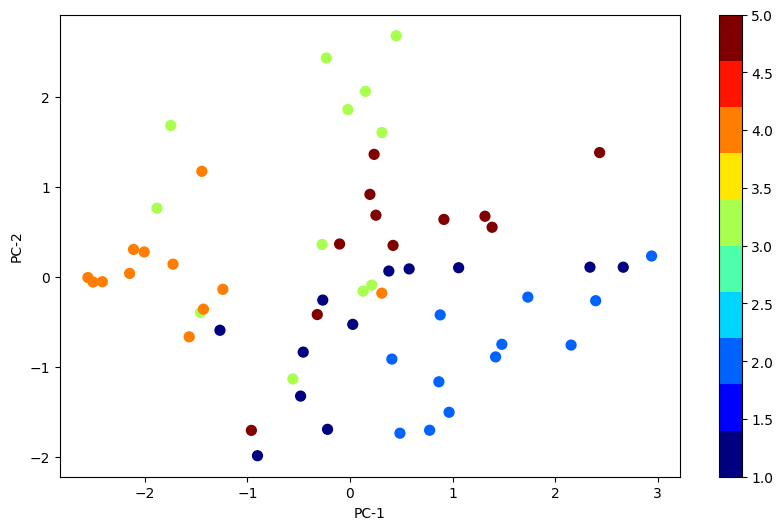

In [91]:
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 10)
plt.scatter(converted_data[:, 0], converted_data[:, 1], s = 50,
            cmap = c_map , c = y_train)
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.show()

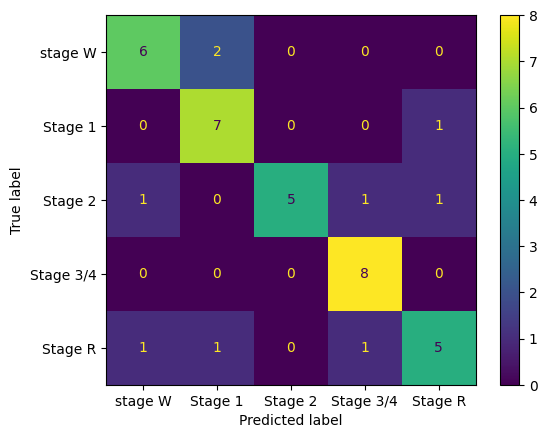

In [92]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=[1,2,3,4,5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ["stage W", "Stage 1", "Stage 2", "Stage 3/4", "Stage R"])
disp.plot()
plt.show()
